# Normalize to 500 KM using MSIS





In [1]:
import pandas as pd
import numpy  as np

from pygeodyn.pygeodyn_plot_scalingfactors import *
import os


### Load GFO

In [2]:
# month_list = ['oct', 'nov', 'dec']#, 'jan', 'feb', 'mar', 'apr']
month_list = ['nov']

ice_file = 'icesat2_6month.csv'
gfo_file = 'gfo_6month.csv'



In [3]:
if os.path.exists(gfo_file) :
    print(gfo_file, ' exists' )

else:
    gfo_bigdf = {}

    for imonth,month in enumerate(month_list):
        if month=='oct':
            m_num = 10
        if month=='nov':
            m_num = 11
        if month=='dec':
            m_num = 12
        if month=='jan':
            m_num = 1
        if month=='feb':
            m_num = 2
        if month=='mar':
            m_num = 3
        if month=='apr':
            m_num = 4

        path_gfo     = "/data/SatDragModelValidation/data/inputs/raw_inputdata/data_GRACEFO/"
        filename_gfo = f'GC_DNS_ACC_2018_{m_num}_v02.txt'

        datapath_gfo     = path_gfo + filename_gfo

        headers = [
            'date',        #         Date (yyyy-mm-dd)
            'time',        #         Time (hh:mm:ss.sss)
            'time_system', #         Time system: UTC or GPS (differs per mission)
            'alt',         #  f10.3  Altitude (m), GRS80
            'lon',         #   f8.3  Geodetic longitude (deg), GRS80
            'lat',         #   f7.3  Geodetic latitude (deg), GRS80
            'lst',         #   f6.3  Local solar time (h)
            'arglat',      #   f7.3  Argument of latitude (deg)
            'dens_x',      #  e15.8  Density derived from accelerometer measurements (kg/m3)
            'dens_mean',   #  e15.8  Running orbit average of density (kg/m3)
            'flag_den',    #   f4.1  Flag for density: 0 = nominal data, 1 = anomalous data (-)
            'flag_orbitavg',#   f4.1  Flag for running orbit average density: 0 = nominal data, 1 = anomalous data (-)
                    ]


        gfo_bigdf[month] = pd.read_csv(datapath_gfo, 
                skiprows = 38, 
                sep = '\s+',
                names = headers,
                           )

        #Convert date from GPS to UTC
        date = pd.to_datetime(\
                            + gfo_bigdf[month]['date']  \
                            + gfo_bigdf[month]['time'], \
                                    format='%Y-%m-%d%H:%M:%S.000') - pd.to_timedelta(18,'s')

        gfo_bigdf[month].insert(0, 'Date', date)

        del gfo_bigdf[month]['date'], gfo_bigdf[month]['time'], date
        del gfo_bigdf[month]['time_system']
        del gfo_bigdf[month]['dens_mean']
        del gfo_bigdf[month]['flag_den']
        del gfo_bigdf[month]['flag_orbitavg']


    #     resid_meas_summry = pd.concat([ gfo_bigdf, resid_meas_summry_iter])

    gfo_df = pd.concat([ gfo_bigdf[month] for month in month_list]  )
    gfo_df = gfo_df.reset_index(drop=True)

    
    
    
    
##### NORMALIZATION OF DATA

if os.path.exists(gfo_file) :
    print(gfo_file, ' exists' )
    gfo_df = pd.read_csv(gfo_file, 
                    sep = ',',
                    )
else:
    print(f"---Calculating Grace-FO normalization")
    D500_gfo = normalize_density_msis2( gfo_df , 'GRACE-FO', 500)
    gfo_df['D500_gfo'] = D500_gfo
    #### save to a csv
    gfo_df.to_csv(gfo_file, index=False)  

    

# gfo_df2 =     gfo_df.query("Date >= '2018-10-14' and Date < '2018-12-30'")
# del gfo_df
    

gfo_6month.csv  exists
gfo_6month.csv  exists


### Load Icesat2

In [4]:
if os.path.exists(ice_file):
    print(ice_file, ' exists' )
    
else:


    %load_ext autoreload
    %autoreload 2
    from gc import collect as gc_collect
    import pickle 
    from datetime import datetime,timedelta

    run_list = ['msis2',
                'jb2008',
                'dtm2020_o']

#     month_list = ['nov']


    scale_cadence = 3

    dir_modeldat='/data/SatDragModelValidation/data/inputs/atmos_models'
    run_dict={}
    for imonth,month in enumerate(month_list):
        for i in run_list:
            if i =='msis2':
                run_dict[month+i]={}
                run_dict[month+i]['num'] = 5
                run_dict[month+i]['model_path'] = None
            if i =='dtm2020_o':
                run_dict[month+i]={}
                run_dict[month+i]['num'] = 3
                run_dict[month+i]['model_path'] = None
            if i =='jb2008':
                run_dict[month+i]={}
                run_dict[month+i]['num'] = 1
                run_dict[month+i]['model_path'] = None

    print(run_dict)



    dir_save    =  '/data/SatDragModelValidation/data/outputs_clean/'\
                 + 'icesat2/O2R2023_longimeperiod/1_DRIAruns/'
    obj = {}
    for imonth,month in enumerate(month_list):
        for i,model in enumerate(run_list):
            pickleName = f'_{month}_DRIA_scale{scale_cadence}.pkl'

            ### Load the data if the pickles exist
            print()
            print()
            gc_collect()

            pickle_file = dir_save+model+pickleName

            filehandler = open(pickle_file, 'rb') 
            obj[month+model] = pickle.load(filehandler)
            filehandler.close()
            print('Loaded data from pickle... ',  month+model)


    ### Save space if doing density retrieval
    for model in run_dict.keys():
        del obj[model]['OrbitResids']
        del obj[model]['Trajectory_orbfil']

    gc_collect()
    
    
    ## MAKE SCALING FACTORS
    
    satid = 1807001
    wgts = {}

    for model in run_dict.keys():
        wgts[model] = {}
        ScalingFactors  = []
        ScalingFactor_times = []

        for ii,arc in enumerate(obj[model]['global_params']['arc_input']):
            epochstart = obj[model]['global_params']['prms']['epoch_start'][ii]
            hrs = pd.to_datetime(epochstart, format='%Y-%m-%d %H:%M:%S').hour
            frachours =(hrs/24)
            #
            if len(arc) == 9:
                maneuv_indicator = arc[8]
            else:
                maneuv_indicator = ''
            arc_type = obj[model]['global_params']['prms']['arc_type']
            if arc_type == "Nominal30hr_and_AB":
                arc_name =arc[:8]+ maneuv_indicator
            else:
                arc_name =arc[:8]+('%.3f'%frachours).lstrip('0')+ maneuv_indicator
            ### Collect the weights for the ensemble average
            inv_rms          = 1/obj[model]['Statistics'][arc_name]['T_RMS'].values[0]
            wgts[model][arc_name] = inv_rms#/sum_wgts

            iters = int(obj[model]['run_parameters'+arc_name]['total_iterations']) 
            for iit, itime in enumerate(obj[model]['AdjustedParams'][arc_name][iters][satid]['0CD'].keys()):
                if iit == 0 or iit==9:
                    pass
                else:
                    CURRENT_VALUE = obj[model]['AdjustedParams'][arc_name][iters][satid]['0CD'][itime]['CURRENT_VALUE']
                    APRIORI_VALUE = obj[model]['AdjustedParams'][arc_name][iters][satid]['0CD'][itime]['APRIORI_VALUE']
                    ScalingFactors.append(CURRENT_VALUE/APRIORI_VALUE)
                    ScalingFactor_times.append(itime)
        run_dict[model]['ScalingFactor_times'] = ScalingFactor_times
        run_dict[model]['ScalingFactors']      = ScalingFactors
        run_dict[model]['Weight'] = wgts[model]



    ###### Scale the densities
    models_dens = {}
    for monthmodel in run_dict.keys():
        print(f"---Making continuous scaled rho for {monthmodel}")
        models_dens[monthmodel] = get_continuous_scaled_densities(obj, run_dict, monthmodel, scale_cadence)


    ## Retrieve scaled ensemble weighted average
    ##     'Rho_x' denotes the ensemble weighted avg
    print(f"---Making ensemble avg")
#     for monthmodel in run_dict.keys():
#         month = monthmodel[:3]
    models_dens =  calc_rho_ScaledEnsembleWgtAvg(models_dens, run_dict, month_list, run_list)


    ### Clear up space 
    del obj
    for monthmodel in run_dict.keys():
        print(monthmodel)
        if 'Rho_x' not in monthmodel:
            del models_dens[monthmodel]

    gc_collect()       

icesat2_6month.csv  exists


## Process normalization

In [5]:
%load_ext autoreload
%autoreload 2
from pygeodyn.pygeodyn_plot_scalingfactors import *

In [6]:
# models_dens

In [7]:
if os.path.exists(ice_file) :
    print(ice_file, ' exists' )
    
    ice_df = pd.read_csv(ice_file, 
                    sep = ',',
                    )
    calc_lst = np.mod(ice_df['lon']/15 + pd.to_datetime(ice_df['date']).dt.hour, 24)
    ice_df['lst'] = calc_lst
    ice_df['Date'] = ice_df['date']
else:
    
    ice_bigdf = {}
    print(f"---Calculating ICESat-2 normalization")
    
    for imonth,month in enumerate(month_list):

        D500_ice = normalize_density_msis2( models_dens[month+'Rho_x'], 'ICESat-2', 500)
        models_dens[month+'Rho_x']['D500_ice'] = D500_ice
        
        ice_bigdf[month] = pd.DataFrame.from_dict(models_dens[month+'Rho_x'])

    
    ice_df = pd.concat([ ice_bigdf[month] for month in month_list]  )
    ice_df = ice_df.reset_index(drop=True)
    ice_df.to_csv(ice_file, index=False)  

    
    


icesat2_6month.csv  exists


In [9]:
gfo_df

,Date,alt,lon,lat,lst,arglat,dens_x,D500_gfo
0,2018-09-30 23:59:42,524856.937,33.987,-64.750,2.430,244.707,1.551779e-14,2.489861e-14
1,2018-09-30 23:59:52,525180.868,34.007,-65.379,2.434,245.340,1.596129e-14,2.577556e-14
2,2018-10-01 00:00:02,525500.386,34.030,-66.008,2.439,245.972,1.616031e-14,2.616757e-14
3,2018-10-01 00:00:12,525815.397,34.056,-66.637,2.443,246.604,1.643293e-14,2.677702e-14
4,2018-10-01 00:00:22,526125.811,34.085,-67.265,2.448,247.236,1.624170e-14,2.663065e-14
...,...,...,...,...,...,...,...,...
1829764,2019-04-30 23:58:52,514836.897,-26.232,-47.025,22.279,313.246,2.902933e-14,3.680779e-14
1829765,2019-04-30 23:59:02,514430.516,-26.251,-46.392,22.280,313.879,2.892206e-14,3.649183e-14
1829766,2019-04-30 23:59:12,514022.979,-26.270,-45.760,22.282,314.512,2.962833e-14,3.719496e-14
1829767,2019-04-30 23:59:22,513614.409,-26.289,-45.127,22.283,315.146,2.964245e-14,3.702103e-14


In [10]:
ice_df

,date,lon,lat,alt,Rho_x,Rho_std,D500_ice,lst,Date
0,2018-10-14 00:00:09,234.8093,-18.3788,488855.712064,2.169541e-13,3.199504e-14,1.768873e-13,15.653953,2018-10-14 00:00:09
1,2018-10-14 00:00:19,234.7430,-17.7401,488633.944291,2.184248e-13,3.198266e-14,1.773812e-13,15.649533,2018-10-14 00:00:19
2,2018-10-14 00:00:29,234.6769,-17.1013,488415.485859,2.198720e-13,3.196680e-14,1.778609e-13,15.645127,2018-10-14 00:00:29
3,2018-10-14 00:00:39,234.6109,-16.4625,488200.405859,2.212931e-13,3.194882e-14,1.783240e-13,15.640727,2018-10-14 00:00:39
4,2018-10-14 00:00:49,234.5451,-15.8235,487988.773655,2.226861e-13,3.192973e-14,1.787704e-13,15.636340,2018-10-14 00:00:49
...,...,...,...,...,...,...,...,...,...
1261435,2019-04-20 23:59:19,281.3090,49.1900,487179.331452,1.019517e-13,5.734402e-15,8.029012e-14,17.753933,2019-04-20 23:59:19
1261436,2019-04-20 23:59:29,281.2163,48.5537,487044.661452,1.022629e-13,5.593053e-15,8.033173e-14,17.747753,2019-04-20 23:59:29
1261437,2019-04-20 23:59:39,281.1248,47.9173,486910.356452,1.025741e-13,5.447882e-15,8.037322e-14,17.741653,2019-04-20 23:59:39
1261438,2019-04-20 23:59:49,281.0345,47.2809,486776.507134,1.028853e-13,5.299860e-15,8.041487e-14,17.735633,2019-04-20 23:59:49


In [17]:
# days = np.arange(0,30)
# dates = pd.date_range(start='11/1/2018', end='12/30/2018')
dates = pd.date_range(start='11/1/2018', end='4/30/2019')


import os
import numpy as np
import matplotlib.pyplot as plt


fig = make_subplots(rows=1, cols=1)

for SAT in ['gfo', 'ice']:
    
    if SAT== 'gfo':
        df = gfo_df
        sat_symbol = 'cross'
        
    if SAT== 'ice':
        df = ice_df
        sat_symbol = 'circle'
        
    

    fns = dates

    # Allocate variables
    ascdescLT = np.zeros((2, len(fns)))
    year = np.zeros(len(fns))
    doy = np.zeros(len(fns))
    avgheight = np.zeros(len(fns))


    # Loop through daily data files
    for ifn, idate in enumerate(dates):

        nday = idate+pd.Timedelta(1,unit='D')
        # Load data for current day
        d = df.query(f"Date >= '{idate.year}-{idate.month:02d}-{idate.day:02d}' and Date < '{nday.year}-{nday.month:02d}-{nday.day:02d}'")

        if d.empty:
            pass
        else:

            d_dict = {}
            d_dict['lat'] = d['lat'].values
            d_dict['lst'] = d['lst'].values
            d_dict['alt'] = d['alt'].values
            #
            d_dict['year'] = pd.to_datetime(d['Date'].values).year.values
            d_dict['doy']  = pd.to_datetime(d['Date'].values).day_of_year.values

            # Find ascending equatorial crossings
            i = np.where(np.diff(d_dict['lat']) > 0)[0]
            j = np.where(np.abs(d_dict['lat'][i]) < 20)[0]
            meanLT1 = np.mean(d_dict['lst'][i[j]])
            stdLT1 = np.std(d_dict['lst'][i[j]])

            # Find descending equatorial crossings
            i = np.where(np.diff(d_dict['lat']) < 0)[0]
            j = np.where(np.abs(d_dict['lat'][i]) < 20)[0]
            meanLT2 = np.mean(d_dict['lst'][i[j]])
            stdLT2 = np.std(d_dict['lst'][i[j]])

            # Find lowest of the two LT standard deviations, ensuring that the
            #  orbit portion away from 0/24LT crossover is chosen
            b = np.argmin([stdLT1, stdLT2])
            ascdescLT[b, ifn] = meanLT1 if b == 0 else meanLT2
            c = 1 if b == 0 else 0                   # index of the highest of the two standard deviations
            ascdescLT[c, ifn] = (meanLT1 + 12) % 24  # offset the more reliable LT by 12 hours

            #   % Find lowest of the two LT standard deviations, ensuring that the orbit portion away from 0/24LT crossover is chosen
            # 	[a,b] = min(stdLT);
            # 	ascdescLT(b,ifn) = meanLT(b);
            # 	c = setxor(b,[1,2]); % index of the highest of the two standard deviations
            # 	ascdescLT(c,ifn) = mod(meanLT(b)+12,24); % offset the more reliable LT by 12 hours

            # Find average height
            i = np.where((d_dict['alt'] < 1e6) & (d_dict['alt'] > 1e5))[0]  # between 100-1000 km
            avgheight[ifn] = 1e-3 * np.mean(d_dict['alt'][i])  # km

            # Store current time
            year[ifn] = d_dict['year'][0]
            doy[ifn] = d_dict['doy'][0]



    ascdescLT[0][ascdescLT[0] == 0.] = np.nan # or use np.nan
    ascdescLT[1][ascdescLT[1] == 0.] = np.nan # or use np.nan
    year[year == 0.] = np.nan # or use np.nan
    doy[doy == 0.] = np.nan # or use np.nan




    fig.add_trace(go.Scattergl(x=year + doy / (365 + (year % 4 == 0)),
                     y=ascdescLT[0],
                     name=SAT+' ascending',
                     mode='markers',
                     opacity=1,
                     marker=dict(size=8,color="#1f77b4",symbol=sat_symbol),
                     showlegend=True),
        secondary_y=False,row=1, col=1)

    fig.add_trace(go.Scattergl(x=year + doy / (365 + (year % 4 == 0)),
                     y=ascdescLT[1],
                     name=SAT+' descending',
                     mode='markers',
                     opacity=1,
                     marker=dict(size=8, color="#ff7f0e",symbol=sat_symbol),
                     showlegend=True),
        secondary_y=False,row=1, col=1)


fig.update_xaxes(title="Year", row=1, col=1)
fig.update_yaxes(title="Local Time (hours)",range=[0,24], row=1, col=1,
        tick0 = 0,
        dtick = 4,
                )

fig.update_layout(autosize=True,legend= {'itemsizing': 'constant'})
fig.show(config=config)



# plt.figure()
# plt.plot(year + doy / (365 + (year % 4 == 0)), ascdescLT[0], '.')
# plt.plot(year + doy / (365 + (year % 4 == 0)), ascdescLT[1], '.')
# # plt.plot(days                                  , ascdescLT, '.')
# # plt.hold(True)
# plt.axis('tight')
# for i in np.arange((2018 + 80 / 365.25 + 0.5), 2023, 0.5):
#     plt.plot([i, i], [0, 24], color=0.7 * np.ones(3))
# plt.plot(plt.xlim(), [6, 6], color=0.7 * np.ones(3))
# plt.plot(plt.xlim(), [18, 18], color=0.7 * np.ones(3))
# co = plt.cm.get_cmap('tab10')
# h = []
# h.append(plt.Polygon(np.array([[np.nan, np.nan], [np.nan, np.nan]]), facecolor=co(0)))
# h.append(plt.Polygon(np.array([[np.nan, np.nan], [np.nan, np.nan]]), facecolor=co(1)))
# plt.legend(h, ['Ascending', 'Descending'])
# # plt.gca().set_layer('top')
# plt.ylim([0, 24])
# plt.yticks(np.arange(0, 25, 6))
# plt.ylabel('Local Time (hours)')
# plt.xlabel('Year')


<ipython-input-17-fec118e83258>:101: RuntimeWarning:

invalid value encountered in remainder

<ipython-input-17-fec118e83258>:110: RuntimeWarning:

invalid value encountered in remainder



<ipython-input-12-9427b073bb82>:3: RuntimeWarning:

invalid value encountered in remainder



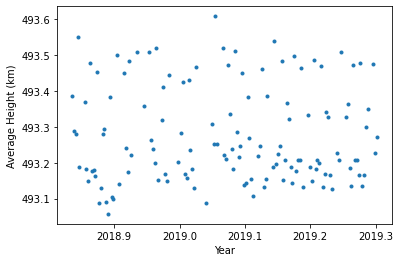

In [12]:

# Plot average height
plt.figure()
plt.plot(year + doy / (365 + (year % 4 == 0)), avgheight, '.')
plt.axis('tight')
# plt.gca().set_layer('top')
plt.ylabel('Average Height (km)')
plt.xlabel('Year')

plt.show()

In [13]:
# plt.figure()
# plt.plot(year + doy / (365 + (year % 4 == 0)), ascdescLT[0], '.')
# plt.plot(year + doy / (365 + (year % 4 == 0)), ascdescLT[1], '.')
# plt.axis('tight')
# for i in np.arange((2018 + 80 / 365.25 + 0.5), 2023, 0.5):
#     plt.plot([i, i], [0, 24], color=0.7 * np.ones(3))
# plt.plot(plt.xlim(), [6, 6], color=0.7 * np.ones(3))
# plt.plot(plt.xlim(), [18, 18], color=0.7 * np.ones(3))
# co = plt.cm.get_cmap('tab10')
# h = []
# h.append(plt.Polygon(np.array([[np.nan, np.nan], [np.nan, np.nan]]), facecolor=co(0)))
# h.append(plt.Polygon(np.array([[np.nan, np.nan], [np.nan, np.nan]]), facecolor=co(1)))
# plt.legend(h, ['Ascending', 'Descending'])
# plt.ylim([0, 24])
# plt.yticks(np.arange(0, 25, 6))
# plt.ylabel('Local Time (hours)')
# plt.xlabel('Year')



# fig = make_subplots(rows=1, cols=1)


# fig.add_trace(go.Scattergl(x=year + doy / (365 + (year % 4 == 0)),
#                  y=ascdescLT[0],
#                  name='ascending',
#                  mode='markers',
#                  opacity=1,
#                  marker=dict(size=4),
#                  showlegend=True),
#     secondary_y=False,row=1, col=1)

# fig.add_trace(go.Scattergl(x=year + doy / (365 + (year % 4 == 0)),
#                  y=ascdescLT[1],
#                  name='descending',
#                  mode='markers',
#                  opacity=1,
#                  marker=dict(size=4),
#                  showlegend=True),
#     secondary_y=False,row=1, col=1)


# fig.update_xaxes(title="Year", row=1, col=1)
# fig.update_yaxes(title="Local Time (hours)",range=[0,24], row=1, col=1,
#         tick0 = 0,
#         dtick = 4,
#                 )

# fig.update_layout(autosize=True,legend= {'itemsizing': 'constant'})
# fig.show(config=config)




In [14]:
# year + doy / (365 + (year % 4 == 0))

In [15]:
# print(idate)
# print(nday)

In [16]:
import sys
sys.exit(0)

SystemExit: 0

/data/miniconda3/envs/pygeodyn/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:

# fig = make_subplots(rows=1, cols=1)


# # fig.add_trace(
# #     go.Scattergl(x=ice_df2['lst'][::10],
# #                  y=ice_df2['lat'][::10],
# #                  name='ICESat2',
# #                  mode='markers',
# #                  opacity=1,
# #                  marker=dict(
# #                     size=3,
# #                     cmax=gfo_df2['D500_gfo'].max(),
# #                     cmin=ice_df2['D500_ice'].min(),
# #                     color=ice_df2['D500_ice'],
# #                     colorbar=dict(title="Density"),colorscale="Viridis"),
# #                  showlegend=False),
# #     secondary_y=False,
# #     row=1, col=1)


# fig.add_trace(
#     go.Scattergl(x=gfo_df2['lst'],
#                  y=gfo_df2['lat'],
#                  name='GRACE-FO',
#                  mode='markers',
#                  opacity=0.5,
# #                  marker=dict( size=3 ),
#                  marker=dict(
#                     size=3,
#                     cmax=gfo_df2['D500_gfo'].max(),
#                     cmin=ice_df2['D500_ice'].min(),
#                     color=gfo_df2['D500_gfo'],
#                     colorbar=dict(title="Density"),colorscale="Viridis"),
#                  showlegend=False),
#     secondary_y=False,
#     row=1, col=1)



# fig.update_xaxes(title="Local solar time (h)", row=1, col=1)
# fig.update_yaxes(title="Geodetic Latitude (deg), GRS80", row=1, col=1)
# fig.update_layout(autosize=True,
#                   legend= {'itemsizing': 'constant'},
#                  )

# fig.show(config=config)



In [ ]:

fig = make_subplots(rows=1, cols=1)


(time_avg, den_gfo ) = orbit_avg_generic(gfo_df['Date'], gfo_df['D500_gfo'], gfo_df['lat'])    
fig.add_trace(go.Scattergl(x=time_avg,
                            y=den_gfo,
                            name=f'GFO_500km',
                            mode='markers',
                            opacity=1,
                            marker=dict( size=4, color='black' ),
                            showlegend=False),
                            row=1, col=1)

(time_avg, den_avg ) = orbit_avg_generic(ice_df['date'],ice_df['D500_ice'],ice_df['lat'])    
fig.add_trace(go.Scattergl(x=time_avg,
                            y=den_avg,
                            name=f'D500_icesat2',
                            mode='markers+lines',
                            opacity=1,
                            marker=dict( size=4, color='blue'),
                            showlegend=False),
                            row=1, col=1)




### SYLIZE LEGEND 
font_dict=dict(family='Arial',size=11,color='black')
## automate the specification of the axes for subplots
rownum, colnum = fig._get_subplot_rows_columns()
for i in rownum:
    if len(rownum)==1:
        L_ticklabel = True
    else:
        if i < len(rownum):
            L_ticklabel = False
        else:
            L_ticklabel = True
    fig.update_xaxes(### LINE at axis border
                      showline=True,
                      showticklabels=L_ticklabel,
#                       tickformat= '%m/%d',
                      linecolor='black',
                      linewidth=1,
                     ### Major ticks
                      ticks='inside',
                      tickfont=font_dict,
                      mirror=True,
#                       tickwidth=2,
#                       ticklen=9,
                      tickcolor='grey',
#                       tick0="2018-11-9" ,
#                       dtick=86400000.0*1,    # milliseconds in a day, every 7 days
                      #### Minor Ticks
                       minor=dict(
                         dtick=86400000.0, # milliseconds in a day
                         tickwidth=1,
                         ticklen=4,
                         tickcolor='grey',
                         ticks='inside'),
                      ### GRID
                       gridcolor='gainsboro',
                       gridwidth=1,
                       layer='above traces',
                       tickangle=0,
                       row=i, col=1)
    fig.update_yaxes(showline=True,      # add line at x=0
                         showticklabels=True,
                         linecolor='black',  # line color
                         linewidth=1,        # line size
                     ticks='inside',     # ticks outside axis
                     tickfont=font_dict, # tick label font
                     mirror='allticks',  # add ticks to top/right axes
                     tickwidth=1,      # tick width
                     tickcolor='black',  # tick color
                     gridcolor='gainsboro',
                     gridwidth=1,
                     layer='above traces',
                     row=i, col=1)


fig.update_yaxes(title_text="Density", 
                 type="log", 
                 exponentformat= 'power',row=1, col=1)
# fig.update_xaxes(title_text="date", 
#                  exponentformat= 'power',row=1, col=1)
fig.update_layout(title="ICESat2 3-hr Scaled Model Rho vs GRACE-FO Rho, All Norm to 500km",
                  autosize=False,    width=1000,    height=700,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict, plot_bgcolor='white', 
                 )

fig.show(config=config)



In [ ]:
import sys
sys.exit()

In [ ]:
%load_ext autoreload
%autoreload 2

from pygeodyn.pygeodyn_plot_scalingfactors import *
import os
import pandas as pd
from netCDF4 import Dataset
def read_nc_file( filename, variables):
    ''' This function reads the TIEGCM .nc files and saves the given input variables to a dictionary.
        The breakloop feature is here so that if the file doesn't exist the code can still continue.  '''
    status = os.path.exists(filename)
    
    if status == True:
        data = {}
        for i, var_names in enumerate(variables):
            ncid =  Dataset(filename,"r+", format="NETCDF4")# filename must be a string
            varData = ncid.variables
            data[var_names] = np.array(varData[var_names])  
    elif status == False:
        print('No File Found', filename )
        breakloop = True
        data = 0
        return( data , breakloop)
    breakloop = False
    return(data,breakloop )


arc_list = []

arc_list_18 = np.arange(270,365)
for i in arc_list_18:
    val = '2018'+str(i)
    arc_list.append(int(val))
    
    #     print(val)
    
# arc_list_19 = np.arange(1,112)
# for i in arc_list_19:
#     val = f"2019{i:03d}"
#     arc_list.append(int(val))


path_to_f107 = '/data/SatDragModelValidation/data/inputs/atmos_models/geo_phys_indicies/gpi_1960001-2021243_f107aDaily.nc'

f107_data = read_nc_file(path_to_f107, ['year_day', 'f107d', 'f107a', 'kp'])


date = []
kp_list = []
f107d_list = []
f107a_list  = []
date_3hr = []
doy_list    = []



for i,val in enumerate(arc_list):
    
    index = f107_data[0]['year_day']==val
    kp_list.append(f107_data[0]['kp'][index][0])
    f107d_list.append(f107_data[0]['f107d'][index][0])
    f107a_list.append(f107_data[0]['f107a'][index][0])
    doy_list.append(str(f107_data[0]['year_day'][index][0])[-3:])

    date.append(pd.to_datetime( str(val), format='%Y%j'))

    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=0))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=3))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=6))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=9))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=12))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=15))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=18))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=21))
#     date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=24))
    
kp_expand = []
for i in kp_list:
    for ii in i:
        kp_expand.append(ii)
        
        
        
solar_fluxes = {}
solar_fluxes['f107d_list'] = f107d_list
solar_fluxes['f107a_list'] = f107a_list
solar_fluxes['date']       = date
solar_fluxes['date_3hr']   = date_3hr
solar_fluxes['kp_expand']  = kp_expand

f107d_earth = []
f107a_earth = []
######################################################################### 
##### Account for the F10.7 at earth (instead of referenced at 1AU) #####
######################################################################### 

for i_doy,val_doy in enumerate(doy_list):
    iday = int(val_doy)
    theta0 = 2 * np.pi * (iday)/365.
    sfeps = 1.000110 + 0.034221*np.cos(theta0)+0.001280* np.sin(theta0) +0.000719*np.cos(2.*theta0)+0.000077*np.sin(2.*theta0)

    f107d_earth.append(sfeps * solar_fluxes['f107d_list'][i_doy])
    f107a_earth.append(sfeps * solar_fluxes['f107a_list'][i_doy])

solar_fluxes['f107d_earth'] = f107d_earth
solar_fluxes['f107a_earth'] = f107a_earth

 
del f107d_earth
del f107a_earth
del kp_expand
del f107d_list
del f107a_list
del date
del date_3hr
del f107_data





In [ ]:

# fig = make_subplots(rows=1, cols=1)
fig = make_subplots(rows=2, cols=1, row_heights=[0.3, 0.7],
                    specs=[[{"secondary_y": True}],
                           [{"secondary_y": True}]],
                           shared_xaxes=True,
                           vertical_spacing=0.02)





fig.add_trace(go.Scatter(x=solar_fluxes['date'],
                           y=solar_fluxes['f107d_earth'],
                           name= 'F107d_1AU',
                           mode='lines',
                           opacity=1,
                           line = dict(shape = 'hvh',dash='dash', color = 'blue', width=2),
                           showlegend=False),
                           secondary_y=True,row=1, col=1)

fig.add_trace(go.Scatter(x=solar_fluxes['date_3hr'],
                           y=solar_fluxes['kp_expand'],
                           name= 'Kp',
                           mode='lines',
                           opacity=1,
                           line = dict(shape = 'hvh', color = 'black', width=2),
                           showlegend=False),
                           secondary_y=False,row=1, col=1) 



(time_avg, den_gfo ) = orbit_avg_generic(gfo_df['Date'], gfo_df['D500_gfo'], gfo_df['lat'])    
fig.add_trace(go.Scattergl(x=time_avg,
                            y=den_gfo,
                            name=f'GFO_500km',
                            mode='markers',
                            opacity=1,
                            marker=dict( size=4, color='black' ),
                            showlegend=False),
                            row=2, col=1)

(time_avg, den_avg ) = orbit_avg_generic(ice_df['datescaled'],ice_df['D500_ice'],ice_df['lat'])    
# remove the datapoints that are definitely artifacts of the orbit average
# 74, 334,  365  

# time_avg[74]=np.nan
# time_avg[334]=np.nan
# time_avg[365]=np.nan
# den_avg[74]=np.nan
# den_avg[334]=np.nan
# den_avg[365]=np.nan


fig.add_trace(go.Scattergl(x=time_avg,
                            y=den_avg,
                            name=f'D500_icesat2',
                            mode='markers',
                            opacity=1,
                            marker=dict( size=4, color='blue'),
                            showlegend=False),
                            row=2, col=1)



#### FANCY LEGEND ################################################################
modelnames=[]
modelcolors = []
# for model in run_list:
#     if model == 'msis2':
#         modelnames.append("MSISe2")
#         modelcolors.append(coldict[model])
#     elif model == 'dtm2020_o':
#         modelnames.append("DTM2020")
#         modelcolors.append(coldict[model])
#     elif model == 'jb2008':
#         modelnames.append("JB2008")
#         modelcolors.append(coldict[model])
modelnames.append("GraceFO")
modelcolors.append('black')
modelnames.append("ICESat2")
modelcolors.append('blue')
df_leg = pd.DataFrame({"starts_colors": modelcolors})
fig.update_traces(showlegend=False).add_traces(
    [   go.Scattergl(name=modelnames[i],
               x=[pd.to_datetime( "181107-000000", format='%y%m%d-%H%M%S')],
               mode='lines',
               line = dict(shape = 'hv',  width=10),
               marker_color=c,
               showlegend=True)
        for i,c in enumerate((df_leg.loc[:,["starts_colors"]].values.ravel()))])
## Legend Control
fig.update_layout(legend=dict(
    yanchor="top",
    y=.65,
    xanchor="center",
    x=.65,
    orientation="h",
        font=dict(family='Arial',size=12,color='black'),
        bgcolor="white",
        bordercolor="darkgrey",
        borderwidth=0.5,)  )
################################################################################


### UPDATE AXES 
fig.update_yaxes(title_text="Kp", 
                 exponentformat= 'power',
                 range=[0,7],
                 secondary_y=False,
                 row=1, col=1)
fig.update_yaxes(title_text="F10.7", 
                 exponentformat= 'power',
                 range=[40,80],
                 secondary_y=True,
                 tickfont=dict(color="blue"),
                 titlefont=dict(color="blue"),
                 row=1, col=1)
################################################################################

### SYLIZE LEGEND 
font_dict=dict(family='Arial',size=11,color='black')
## automate the specification of the axes for subplots
rownum, colnum = fig._get_subplot_rows_columns()
for i in rownum:
    if len(rownum)==1:
        L_ticklabel = False
    else:
        if i < len(rownum):
            L_ticklabel = False
        else:
            L_ticklabel = True
    fig.update_xaxes(### LINE at axis border
                      showline=True,
                      showticklabels=L_ticklabel,
#                       tickformat= '%m/%d',
                      linecolor='black',
                      linewidth=1,
                     ### Major ticks
                      ticks='inside',
                      tickfont=font_dict,
                      mirror=True,
#                       tickwidth=2,
#                       ticklen=9,
                      tickcolor='grey',
#                       tick0="2018-11-9" ,
#                       dtick=86400000.0*1,    # milliseconds in a day, every 7 days
                      #### Minor Ticks
                       minor=dict(
                         dtick=86400000.0, # milliseconds in a day
                         tickwidth=1,
                         ticklen=4,
                         tickcolor='grey',
                         ticks='inside'),
                      ### GRID
                       gridcolor='gainsboro',
                       gridwidth=1,
                       layer='above traces',
                       tickangle=0,
                       row=i, col=1)
    fig.update_yaxes(showline=True,      # add line at x=0
                         showticklabels=True,
                         linecolor='black',  # line color
                         linewidth=1,        # line size
                     ticks='inside',     # ticks outside axis
                     tickfont=font_dict, # tick label font
                     mirror='allticks',  # add ticks to top/right axes
                     tickwidth=1,      # tick width
                     tickcolor='black',  # tick color
                     gridcolor='gainsboro',
                     gridwidth=1,
                     layer='above traces',
                     row=i, col=1)


fig.update_xaxes(range=[pd.to_datetime( "181101-000000", format='%y%m%d-%H%M%S'),
                        pd.to_datetime( "181130-000000", format='%y%m%d-%H%M%S')],row=1, col=1)


fig.update_yaxes(title_text="Density", 
#                  type="log", 
                 exponentformat= 'power',row=2, col=1)
fig.update_layout(title="ICESat2 3-hr Scaled Model Rho vs GRACE-FO Rho, All Norm to 500km",
                  autosize=False,    width=1000,    height=700,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict, plot_bgcolor='white', 
                 )

fig.show(config=config)



In [ ]:

# fig = make_subplots(rows=1, cols=1)




# # fig.add_trace(go.Scattergl(x=gfo_df['Date'][:10000],
# #                             y=gfo_df['D500_gfo'][:10000],
# #                             name=f'D500_gfo',
# #                             mode='markers',
# #                             opacity=1,
# #                             marker=dict( size=4 ),
# #                             showlegend=True),
# #                             row=1, col=1)

# # fig.add_trace(go.Scattergl(x=ice_df['datescaled'],
# #                             y=ice_df['D500_ice'],
# #                             name=f'D500_icesat2',
# #                             mode='markers',
# #                             opacity=1,
# #                             marker=dict( size=4 ),
# #                             showlegend=True),
# #                             row=1, col=1)
# (time_avg, den_gfo ) = orbit_avg_generic(gfo_df['Date'], gfo_df['D500_gfo'], gfo_df['lat'])    
# fig.add_trace(go.Scattergl(x=time_avg,
#                             y=den_gfo,
#                             name=f'D500_gfo',
#                             mode='markers',
#                             opacity=1,
#                             marker=dict( size=4 ),
#                             showlegend=True),
#                             row=1, col=1)

# (time_avg, den_avg ) = orbit_avg_generic(ice_df['datescaled'],ice_df['D500_ice'],ice_df['lat'])    
# # remove the datapoints that are definitely artifacts of the orbit average
# # 74, 334,  365  

# time_avg[74]=np.nan
# time_avg[334]=np.nan
# time_avg[365]=np.nan
# den_avg[74]=np.nan
# den_avg[334]=np.nan
# den_avg[365]=np.nan


# fig.add_trace(go.Scattergl(x=time_avg,
#                             y=den_avg,
#                             name=f'D500_icesat2',
#                             mode='markers',
#                             opacity=1,
#                             marker=dict( size=4 ),
#                             showlegend=True),
#                             row=1, col=1)



# ### SYLIZE AXES 
# font_dict=dict(family='Arial',size=11,color='black')
# ## automate the specification of the axes for subplots
# rownum, colnum = fig._get_subplot_rows_columns()
# for i in rownum:
#     if len(rownum)==1:
#         L_ticklabel = True
#     else:
#         if i < len(rownum):
#             L_ticklabel = True
#         else:
#             L_ticklabel = True
#     fig.update_xaxes(### LINE at axis border
#                       showline=True,
#                       showticklabels=L_ticklabel,
# #                       tickformat= '%m/%d',
#                       linecolor='black',
#                       linewidth=1,
#                      ### Major ticks
#                       ticks='inside',
#                       tickfont=font_dict,
#                       mirror=True,
# #                       tickwidth=2,
# #                       ticklen=9,
#                       tickcolor='grey',
# #                       tick0="2018-11-9" ,
# #                       dtick=86400000.0*1,    # milliseconds in a day, every 7 days
#                       #### Minor Ticks
#                        minor=dict(
#                          dtick=86400000.0, # milliseconds in a day
#                          tickwidth=1,
#                          ticklen=4,
#                          tickcolor='grey',
#                          ticks='inside'),
#                       ### GRID
#                        gridcolor='gainsboro',
#                        gridwidth=1,
#                        layer='above traces',
#                        tickangle=0,
#                        row=i, col=1)
#     fig.update_yaxes(showline=True,      # add line at x=0
#                          showticklabels=True,
#                          linecolor='black',  # line color
#                          linewidth=1,        # line size
#                      ticks='inside',     # ticks outside axis
#                      tickfont=font_dict, # tick label font
#                      mirror='allticks',  # add ticks to top/right axes
#                      tickwidth=1,      # tick width
#                      tickcolor='black',  # tick color
#                      gridcolor='gainsboro',
#                      gridwidth=1,
#                      layer='above traces',
#                      row=i, col=1)




# fig.update_yaxes(title_text="Density", 
#                  type="log", 
#                  exponentformat= 'power',row=1, col=1)
# fig.update_layout(#title="ICESat2 3-hr Scaled Model Rho vs GRACE-FO Rho",
#                   autosize=True,#    width=1000,    height=700,
#                   legend= {'itemsizing': 'trace'},
#                   font=font_dict, plot_bgcolor='white', 
#                  )

# fig.show(config=config)



In [ ]:
for i,val in enumerate(time_avg):
    print(i,val)

# 74, 334,  365  
#25th
#29th

In [ ]:
pd.to_datetime('2018-11-07 00:19:14')

In [ ]:
import sys
sys.exit()

In [ ]:
np.where(time_avg==pd.to_datetime('2018-11-07 00:19:14'))

In [ ]:

fig = make_subplots(rows=1, cols=1)




# fig.add_trace(go.Scattergl(x=gfo_df['Date'],
#                             y=gfo_df['D500_gfo'],
#                             name=f'D500_gfo',
#                             mode='markers',
#                             opacity=1,
#                             marker=dict( size=4 ),
#                             showlegend=True),
#                             row=1, col=1)

fig.add_trace(go.Scattergl(x=ice_df['dates'],
                            y=ice_df['D500_ice'],
                            name=f'D500_icesat2',
                            mode='markers',
                            opacity=1,
                            marker=dict( size=4 ),
                            showlegend=True),
                            row=1, col=1)

fig.add_trace(go.Scattergl(x=ice_df['dates'],
                            y=ice_df['Rho_x'],
                            name=f'Rho_x_icesat2',
                            mode='markers',
                            opacity=1,
                            marker=dict( size=4 ),
                            showlegend=True),
                            row=1, col=1)



### SYLIZE AXES 
font_dict=dict(family='Arial',size=11,color='black')
## automate the specification of the axes for subplots
rownum, colnum = fig._get_subplot_rows_columns()
for i in rownum:
    if len(rownum)==1:
        L_ticklabel = True
    else:
        if i < len(rownum):
            L_ticklabel = True
        else:
            L_ticklabel = True
    fig.update_xaxes(### LINE at axis border
                      showline=True,
                      showticklabels=L_ticklabel,
#                       tickformat= '%m/%d',
                      linecolor='black',
                      linewidth=1,
                     ### Major ticks
                      ticks='inside',
                      tickfont=font_dict,
                      mirror=True,
#                       tickwidth=2,
#                       ticklen=9,
                      tickcolor='grey',
#                       tick0="2018-11-9" ,
#                       dtick=86400000.0*1,    # milliseconds in a day, every 7 days
                      #### Minor Ticks
                       minor=dict(
                         dtick=86400000.0, # milliseconds in a day
                         tickwidth=1,
                         ticklen=4,
                         tickcolor='grey',
                         ticks='inside'),
                      ### GRID
                       gridcolor='gainsboro',
                       gridwidth=1,
                       layer='above traces',
                       tickangle=0,
                       row=i, col=1)
    fig.update_yaxes(showline=True,      # add line at x=0
                         showticklabels=True,
                         linecolor='black',  # line color
                         linewidth=1,        # line size
                     ticks='inside',     # ticks outside axis
                     tickfont=font_dict, # tick label font
                     mirror='allticks',  # add ticks to top/right axes
                     tickwidth=1,      # tick width
                     tickcolor='black',  # tick color
                     gridcolor='gainsboro',
                     gridwidth=1,
                     layer='above traces',
                     row=i, col=1)




fig.update_yaxes(title_text="Density", 
                 type="log", 
                 exponentformat= 'power',row=1, col=1)
fig.update_layout(#title="ICESat2 3-hr Scaled Model Rho vs GRACE-FO Rho",
                  autosize=True,#    width=1000,    height=700,
                  legend= {'itemsizing': 'trace'},
                  font=font_dict, plot_bgcolor='white', 
                 )

fig.show(config=config)



In [ ]:
# import pandas as pd
# import numpy as np 
# import sys  
# from scipy.io import loadmat  #allows us to read in .mat files
# from datetime import datetime, timedelta
# import gc

# #### MAKE MSIS Take the 3HR Ap values
# from pymsis import msis
# SWI_option = [1.0]*25
# SWI_option[8] = -1.0
#             #  C    AP - MAGNETIC INDEX(DAILY) OR WHEN SW(9)=-1. :
#             #  C      - ARRAY CONTAINING:
#             #  C       (1) DAILY AP
#             #  C       (2) 3 HR AP INDEX FOR CURRENT TIME
#             #  C       (3) 3 HR AP INDEX FOR 3 HRS BEFORE CURRENT TIME
#             #  C       (4) 3 HR AP INDEX FOR 6 HRS BEFORE CURRENT TIME
#             #  C       (5) 3 HR AP INDEX FOR 9 HRS BEFORE CURRENT TIME
#             #  C       (6) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 12 TO 33 HRS PRIOR
#             #  C          TO CURRENT TIME
#             #  C       (7) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 36 TO 57 HRS PRIOR
#             #  C          TO CURRENT TIME


# #################################
# years =  [2002]#, 2003, 2004, 2005, 2006, 2007, 2008, 2009]
# days = np.arange(1,2)
# path_champ = '/space/DNR_data/CHAMP_2002_2010/'
# #################################


# def make_champ_timeseries_v2_redorenorm(years, days):

#     """This function redoes the construction of the CHAMP timeseries for the orbit.

#     Changes from the original include:
#         - Use F10.7 indicies that are scaled with MgII and re-referenced to the Earth's locatiion (instead of at 1AU)
#         - Use MSIS2.0 for the normalization to 400km
#         - Use a 3Hour Ap input as required by MSIS for the more granular Stormtime forcing option.




#     """    


#     path_champ = '/space/DNR_data/CHAMP_2002_2010/'


#     #### Load MgII Scaled F10.7 Values:
#     import pickle
#     dir_save = '/space/DNR_data/'
#     filehandler = open(dir_save+'MgII_F107_KpAp'+'.pkl', 'rb') 
#     mgII_data = pickle.load(filehandler)
#     filehandler.close()

#     #### clear up some space        
#     truncate_date    = np.logical_and(mgII_data['Date'].year>=2000 , mgII_data['Date'].year<=2011 )
#     truncate_date3hr =  np.logical_and(mgII_data['Date_3hrAp'].year>=2000 , mgII_data['Date_3hrAp'].year<=2011 )#np.logical_and(mgII_data['Date_3hrAp'].year==year , mgII_data['Date_3hrAp'].dayofyear==day )

#     mgII_data['Date_3hrAp'] = mgII_data['Date_3hrAp'][truncate_date3hr]
#     mgII_data['Ap']         = np.array(mgII_data['Ap'])[truncate_date3hr]
#     mgII_data['Date']       = mgII_data['Date'][truncate_date]
#     mgII_data['Ap_dailyavg'] =  np.array(mgII_data['Ap_dailyavg'])[truncate_date]
#     mgII_data['f107d_earth'] = np.array(mgII_data['f107d_earth'])[truncate_date]
#     mgII_data['f107a_earth'] = np.array(mgII_data['f107a_earth'])[truncate_date]

#     del mgII_data['DOY']
#     del mgII_data['kp']
#     del mgII_data['f107d']
#     del mgII_data['f107a']
#     del mgII_data['year_day']




#     #     noaa = pd.read_pickle('/space/DNR_data/noaa_2002_2010_pickle')
#     #     noaa['f107d'][noaa['f107d'].astype(float) <= 60] = noaa['f107a'][noaa['f107d'].astype(float) <= 60]

#     tleng = 0
#     time_full= []
#     Year         = []
#     Doy          = []
#     Hours        = []
#     Lon          = []
#     Lat          = []
#     LatBin       = []
#     Height       = []
#     LocTim       = []
#     CHAMPDensity = []
#     D400_msis00  = []  # normalized quantity
#     rhosat_msis00= []
#     rhosat_msis2 = np.ones(2000*np.size(years)*np.size(days))*np.nan
#     rho400_msis2 = np.ones(2000*np.size(years)*np.size(days))*np.nan
#     D400_msis2   = np.ones(2000*np.size(years)*np.size(days))*np.nan

#     rhosat_tiegcm = np.ones(2000*np.size(years)*np.size(days))*np.nan
#     rho400_tiegcm = np.ones(2000*np.size(years)*np.size(days))*np.nan
#     D400_tiegcm   = np.ones(2000*np.size(years)*np.size(days))*np.nan

#     #     Cd           = []
#     # Ap_dayvals   = []
#     # f107a_dayvals= []
#     # f107d_dayvals= []
#     date = []

#     i = 0
#     for iyear,year in enumerate(years):
#         for iday,day in enumerate(days):
#                 ####---------------------------------------------
#                 #### Gather the Necessary Flux and Ap Information
#                 index_date = np.logical_and(mgII_data['Date'].year==year , mgII_data['Date'].dayofyear==day )
#                 f107a = float(np.squeeze(np.asarray(mgII_data['f107a_earth'])[index_date]))
#                 f107d = float(np.squeeze(np.asarray(mgII_data['f107d_earth'])[index_date]))
#                 Ap_daily_avg = float(np.squeeze(np.asarray(mgII_data['Ap_dailyavg'])[index_date]))


#                 ### Construct the necessary 3hr Ap Array to go into MSIS
# #                 print(f"----------------------------------------------------------")

#                 print(f"Year: {year} / Day: {day}")
#                 for it, itime in enumerate( champ['Hours'][:leng]):

#                     lon   = champ['Lon'][it]
#                     lat   = champ['Lat'][it]
#                     dates = datetime(year, 1, 1) + timedelta(float(day) - 1) + timedelta(hours = champ['Hours'][it]) 
#                     f107din = [f107d]
#                     f107ain = [f107a]
#                     time_sat = itime

#                     if str(interpolate_tiegcm(TIEGCM, lon, lat, time_sat, 400,                 'DEN')*1e3)=='-inf':
#                         print('-inf FOUND')
#                         continue
#                     elif str(interpolate_tiegcm(TIEGCM, lon, lat, time_sat, 400,                 'DEN')*1e3)=='inf':
#                         print('inf FOUND')
#                         continue
#                     else:
#                         date.append(datetime(year, 1, 1) + timedelta(days = float(day)-1,  hours = itime )) 

#                         index_date3hr = np.logical_and(mgII_data['Date_3hrAp'].year==year , mgII_data['Date_3hrAp'].dayofyear==day )
#                         indexvals =  [i for i, x in enumerate(index_date3hr) if x]
#                         Ap_doy_windows = mgII_data['Date_3hrAp'][indexvals]

#                         #### Find the Current 3hr Kp window:A
#                         Ap_windw_hrs = [i.hour for i in Ap_doy_windows]
#                         Ap_windw_hrs = np.append(np.array(Ap_windw_hrs),24)  ## add the final window edge

#                         index_current_Ap = int(np.digitize([dates.hour],Ap_windw_hrs))
#                         if index_current_Ap==8:
#                             index_current_Ap += -1
#                         indexglobal_currentAp = indexvals[index_current_Ap]

#                         Ap_3HR_current        = mgII_data['Ap'][indexglobal_currentAp]
#                         Ap_3HR_prior          = mgII_data['Ap'][indexglobal_currentAp-1]
#                         Ap_6HR_prior          = mgII_data['Ap'][indexglobal_currentAp-2]
#                         Ap_9HR_prior          = mgII_data['Ap'][indexglobal_currentAp-3]
#                         Ap_12hr_33hr_priorAVG = np.mean(mgII_data['Ap'][indexglobal_currentAp-11 :indexglobal_currentAp-3 ] ) ### 33hrs to 12 hours
#                         Ap_36hr_57hr_priorAVG = np.mean(mgII_data['Ap'][indexglobal_currentAp-19 :indexglobal_currentAp-11 ])  ### 36hrs to 57 hours

#                         apsin = [[Ap_daily_avg,          # (1) DAILY AP
#                                   Ap_3HR_current,        # (2) 3 HR AP INDEX FOR CURRENT TIME
#                                   Ap_3HR_prior,          # (3) 3 HR AP INDEX FOR 3 HRS BEFORE CURRENT TIME
#                                   Ap_6HR_prior,          # (4) 3 HR AP INDEX FOR 6 HRS BEFORE CURRENT TIME
#                                   Ap_9HR_prior,          # (5) 3 HR AP INDEX FOR 9 HRS BEFORE CURRENT TIME
#                                   Ap_12hr_33hr_priorAVG, # (6) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 12 TO 33 HRS PRIOR
#                                   Ap_36hr_57hr_priorAVG]]# (7) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 36 TO 57 HRS PRIOR

#                         output2_sat = msis.run(dates, lon, lat, champ['Height'][it], f107din, f107ain, apsin, version = 2, options=SWI_option)
#                         output2_400 = msis.run(dates, lon, lat, 400, f107din, f107ain, apsin                , version = 2, options=SWI_option)



#                         ### add the values to the growing lists
#                         rhosat_msis2[tleng+it] = output2_sat[0,0,0,0][0]
#                         rho400_msis2[tleng+it] = output2_400[0,0,0,0][0]
#                         ### RENORMALIZE with MSIS2
#                         D400_msis2[tleng+it]   = champ['Density'][it] * (output2_400[0,0,0,0][0] / output2_sat[0,0,0,0][0])   # normalized density to 400km with MSIS2

#                         ##### Interpolate the TIEGCM Data to the Satellites Position and Time
# #                         print(time_sat)
# #                         print(lon)
# #                         print(lat)
# #                         print(interpolate_tiegcm(TIEGCM, lon, lat, time_sat, champ['Height'][it], 'DEN')*1e3)
# #                         print(interpolate_tiegcm(TIEGCM, lon, lat, time_sat, 400,                 'DEN')*1e3)
#                         val_tiegcm_sat = interpolate_tiegcm(TIEGCM, lon, lat, time_sat, champ['Height'][it], 'DEN')*1e3
#                         val_tiegcm_400 = interpolate_tiegcm(TIEGCM, lon, lat, time_sat, 400,                 'DEN')*1e3
#                         rhosat_tiegcm[tleng+it] = val_tiegcm_sat
#                         rho400_tiegcm[tleng+it] = val_tiegcm_400
#                         ### RENORMALIZE with TIEGCM
# #                         print('msis2', champ['Density'][it] * (output2_400[0,0,0,0][0] / output2_sat[0,0,0,0][0]))
# #                         print('val_tiegcm_sat', val_tiegcm_sat)
# #                         print('val_tiegcm_400', val_tiegcm_400)
# #                         print('tiegcm', champ['Density'][it] * (val_tiegcm_400 / val_tiegcm_sat))
#                         D400_tiegcm[tleng+it]   = champ['Density'][it] * (val_tiegcm_400 / val_tiegcm_sat)   # normalized density to 400km with TIEGCM



#                 tleng = tleng + leng
#     #                 print(year,'/',day)
#                 i+=1
#                 print('Closing', sec_file)
#                 ncid =  Dataset(sec_file,"r+", format="NETCDF4")        
#                 ncid.close()
#                 gc.collect()


#             elif breakloop == True:
#                 i+=1
#                 continue

#     #### REMOVE NANS
#     # From Msis lists
#     rhosat_msis2 = rhosat_msis2[~np.isnan(rhosat_msis2)]
#     rho400_msis2 = rho400_msis2[~np.isnan(rho400_msis2)]
#     D400_msis2   = D400_msis2[~np.isnan(D400_msis2)]
#     # From tiegcm lists
#     rhosat_tiegcm = rhosat_tiegcm[~np.isnan(rhosat_tiegcm)]
#     rho400_tiegcm = rho400_tiegcm[~np.isnan(rho400_tiegcm)]
#     D400_tiegcm   = D400_tiegcm[~np.isnan(D400_tiegcm)]


#     df = pd.DataFrame(data={'Date' :date ,
#                             'Year'          : Year,
#                             'Doy'           : Doy,
#                             'Hours'         : Hours,
#                             'Lon'           : Lon,
#                             'Lat'           : Lat, 
#                             'LatBin'        : LatBin,
#                             'Height'        : Height,
#                             'LocTim'        : LocTim,
#                             'CHAMPDensity'  : CHAMPDensity,
#                             'rhosat_msis00' : rhosat_msis00, ### MSIS00 density @Satellite Altitude
#                             'rhosat_msis2'  : rhosat_msis2,  ### MSIS2 density @Satellite Altitude
#                             'D400_msis00'   : D400_msis00,   ### density normalized to 400km with msis00
#                             'rho400_msis2'  : rho400_msis2,  ### MSIS2 density @400km 
#                             'D400_msis2'    : D400_msis2,    ### density normalized to 400km with msis2
#                             #
#                             'rhosat_tiegcm'  : rhosat_tiegcm,  ### Tiegcm density @Satellite Altitude
#                             'rho400_tiegcm'  : rho400_tiegcm,  ### Tiegcm density @400km 
#                             'D400_tiegcm'    : D400_tiegcm,    ### density normalized to 400km with Tiegcm
#                             #                             'Cd'            : Cd,
#     #                         'Ap_dayvals'    : Ap_dayvals,
#     #                         'f107a_dayvals' : f107a_dayvals,
#     #                         'f107d_dayvals' : f107d_dayvals,
#                   } )

#     df.to_pickle('parallelize/RenormChampWithMSIS2_'+str(year))

    
#     return(df)    



# # import pandas as pd
# # import numpy as np 
# # import sys  
# # from scipy.io import loadmat  #allows us to read in .mat files
# # from datetime import datetime, timedelta

# # #### MAKE MSIS Take the 3HR Ap values
# # from pymsis import msis
# # SWI_option = [1.0]*25
# # SWI_option[8] = -1.0
# #             #  C    AP - MAGNETIC INDEX(DAILY) OR WHEN SW(9)=-1. :
# #             #  C      - ARRAY CONTAINING:
# #             #  C       (1) DAILY AP
# #             #  C       (2) 3 HR AP INDEX FOR CURRENT TIME
# #             #  C       (3) 3 HR AP INDEX FOR 3 HRS BEFORE CURRENT TIME
# #             #  C       (4) 3 HR AP INDEX FOR 6 HRS BEFORE CURRENT TIME
# #             #  C       (5) 3 HR AP INDEX FOR 9 HRS BEFORE CURRENT TIME
# #             #  C       (6) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 12 TO 33 HRS PRIOR
# #             #  C          TO CURRENT TIME
# #             #  C       (7) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 36 TO 57 HRS PRIOR
# #             #  C          TO CURRENT TIME

# # import sys  
# # sys.path.insert(0, 'util_funcs/')
# # from read_CHAMP_data import get_CHAMP_data

# # # #################################
# # # years =  [2002]#, 2003, 2004, 2005, 2006, 2007, 2008, 2009]
# # # days = np.arange(1,2)
# # # path_champ = '/space/DNR_data/CHAMP_2002_2010/'
# # # #################################


# # def make_champ_timeseries_v2_redorenorm(years, days):
    
# #     """This function redoes the construction of the CHAMP timeseries for the orbit.
    
# #     Changes from the original include:
# #         - Use F10.7 indicies that are scaled with MgII and re-referenced to the Earth's locatiion (instead of at 1AU)
# #         - Use MSIS2.0 for the normalization to 400km
# #         - Use a 3Hour Ap input as required by MSIS for the more granular Stormtime forcing option.
        
        
        
        
# #     """    

    
# #     path_champ = '/space/DNR_data/CHAMP_2002_2010/'
    
    
# #     #### Load MgII Scaled F10.7 Values:
# #     import pickle
# #     dir_save = '/space/DNR_data/'
# #     filehandler = open(dir_save+'MgII_F107_KpAp'+'.pkl', 'rb') 
# #     mgII_data = pickle.load(filehandler)
# #     filehandler.close()
        
# #     #### clear up some space        
# #     truncate_date    = np.logical_and(mgII_data['Date'].year>=2000 , mgII_data['Date'].year<=2011 )
# #     truncate_date3hr =  np.logical_and(mgII_data['Date_3hrAp'].year>=2000 , mgII_data['Date_3hrAp'].year<=2011 )#np.logical_and(mgII_data['Date_3hrAp'].year==year , mgII_data['Date_3hrAp'].dayofyear==day )

# #     mgII_data['Date_3hrAp'] = mgII_data['Date_3hrAp'][truncate_date3hr]
# #     mgII_data['Ap']         = np.array(mgII_data['Ap'])[truncate_date3hr]
# #     mgII_data['Date']       = mgII_data['Date'][truncate_date]
# #     mgII_data['Ap_dailyavg'] =  np.array(mgII_data['Ap_dailyavg'])[truncate_date]
# #     mgII_data['f107d_earth'] = np.array(mgII_data['f107d_earth'])[truncate_date]
# #     mgII_data['f107a_earth'] = np.array(mgII_data['f107a_earth'])[truncate_date]

# #     del mgII_data['DOY']
# #     del mgII_data['kp']
# #     del mgII_data['f107d']
# #     del mgII_data['f107a']
# #     del mgII_data['year_day']
        
        
        
        
# #     #     noaa = pd.read_pickle('/space/DNR_data/noaa_2002_2010_pickle')
# #     #     noaa['f107d'][noaa['f107d'].astype(float) <= 60] = noaa['f107a'][noaa['f107d'].astype(float) <= 60]

# #     tleng = 0
# #     time_full= []
# #     Year         = []
# #     Doy          = []
# #     Hours        = []
# #     Lon          = []
# #     Lat          = []
# #     LatBin       = []
# #     Height       = []
# #     LocTim       = []
# #     CHAMPDensity = []
# #     D400_msis00  = []  # normalized quantity
# #     rhosat_msis00= []
# #     rhosat_msis2 = np.ones(2000*np.size(years)*np.size(days))*np.nan
# #     rho400_msis2 = np.ones(2000*np.size(years)*np.size(days))*np.nan
# #     D400_msis2   = np.ones(2000*np.size(years)*np.size(days))*np.nan
# # #     Cd           = []
# #     # Ap_dayvals   = []
# #     # f107a_dayvals= []
# #     # f107d_dayvals= []
# #     date = []

# #     i = 0
# #     for iyear,year in enumerate(years):
# #         for iday,day in enumerate(days):
# #             champ, breakloop = get_CHAMP_data(path_champ, year, day) 
# #             if breakloop == False:
# #                 leng = np.size(champ,0)
# #     #                 date_index = datetime(year, 1, 1) + timedelta(float(day)) 
# #     #                 Ap_old    = float(noaa['Ap'][date_index])
# #     #                 f107a_old = float(noaa['f107a'][date_index])
# #     #                 f107d_old = float(noaa['f107d'][date_index])
# #                 leng2 = leng+tleng

# #                 Year[tleng:leng2]          = champ['Year'][:leng]
# #                 Doy[tleng:leng2]           = champ['Doy'][:leng]
# #                 Hours[tleng:leng2]         = champ['Hours'][:leng]
# #                 Lon[tleng:leng2]           = champ['Lon'][:leng]
# #                 Lat[tleng:leng2]           = champ['Lat'][:leng]
# #                 LatBin[tleng:leng2]        = champ['LatBin'][:leng]
# #                 Height[tleng:leng2]        = champ['Height'][:leng]
# #                 LocTim[tleng:leng2]        = champ['LocTim'][:leng]
# #                 CHAMPDensity[tleng:leng2]  = champ['Density'][:leng]
# #                 D400_msis00[tleng:leng2]   = champ['D400'][:leng]
# #                 rhosat_msis00[tleng:leng2] = champ['Dmsis'][:leng]
# # #                 Cd[tleng:leng2]            = champ['Cd'][:leng]


# #                 ####---------------------------------------------
# #                 #### Gather the Necessary Flux and Ap Information
# #                 index_date = np.logical_and(mgII_data['Date'].year==year , mgII_data['Date'].dayofyear==day )
# #                 f107a = float(np.squeeze(np.asarray(mgII_data['f107a_earth'])[index_date]))
# #                 f107d = float(np.squeeze(np.asarray(mgII_data['f107d_earth'])[index_date]))
# #                 Ap_daily_avg = float(np.squeeze(np.asarray(mgII_data['Ap_dailyavg'])[index_date]))


# #                 ### Construct the necessary 3hr Ap Array to go into MSIS
# #     #             print('---------------------------------------------')
# #                 print(f"Year: {year} / Day: {day}")
# #     #             daily_avg_ap = np.mean(Ap)
# #                 for it, itime in enumerate( champ['Hours'][:leng]):
# #                     date.append(datetime(year, 1, 1) + timedelta(days = float(day)-1,  hours = itime )) 

# #                     lon   = champ['Lon'][it]
# #                     lat   = champ['Lat'][it]
# #                     dates = datetime(year, 1, 1) + timedelta(float(day) - 1) + timedelta(hours = champ['Hours'][it]) 
# #                     f107din = [f107d]
# #                     f107ain = [f107a]

# #                     index_date3hr = np.logical_and(mgII_data['Date_3hrAp'].year==year , mgII_data['Date_3hrAp'].dayofyear==day )
# #                     indexvals =  [i for i, x in enumerate(index_date3hr) if x]
# #                     Ap_doy_windows = mgII_data['Date_3hrAp'][indexvals]

# #                     #### Find the Current 3hr Kp window:A
# #                     Ap_windw_hrs = [i.hour for i in Ap_doy_windows]
# #                     Ap_windw_hrs = np.append(np.array(Ap_windw_hrs),24)  ## add the final window edge

# #                     index_current_Ap = int(np.digitize([dates.hour],Ap_windw_hrs))
# #                     if index_current_Ap==8:
# #                         index_current_Ap += -1
# #                     indexglobal_currentAp = indexvals[index_current_Ap]

# #                     Ap_3HR_current        = mgII_data['Ap'][indexglobal_currentAp]
# #                     Ap_3HR_prior          = mgII_data['Ap'][indexglobal_currentAp-1]
# #                     Ap_6HR_prior          = mgII_data['Ap'][indexglobal_currentAp-2]
# #                     Ap_9HR_prior          = mgII_data['Ap'][indexglobal_currentAp-3]
# #                     Ap_12hr_33hr_priorAVG = np.mean(mgII_data['Ap'][indexglobal_currentAp-11 :indexglobal_currentAp-3 ] ) ### 33hrs to 12 hours
# #                     Ap_36hr_57hr_priorAVG = np.mean(mgII_data['Ap'][indexglobal_currentAp-19 :indexglobal_currentAp-11 ])  ### 36hrs to 57 hours

# #                     #### CHECK THE DATES!!!!
# #                     # print(f'      Current Date: {dates}')
# #                     # print('3HR_current ', mgII_data['Date_3hrAp'][indexglobal_currentAp])
# #                     # print('3HR_prior ', mgII_data['Date_3hrAp'][indexglobal_currentAp-1])
# #                     # print('6HR_prior ', mgII_data['Date_3hrAp'][indexglobal_currentAp-2])
# #                     # print('9HR_prior ', mgII_data['Date_3hrAp'][indexglobal_currentAp-3])
# #                     # print('12hr_33hr_priorAVG ', mgII_data['Date_3hrAp'][indexglobal_currentAp-11 :indexglobal_currentAp-3 ]  )
# #                     # print('36hr_57hr_priorAVG ', mgII_data['Date_3hrAp'][indexglobal_currentAp-19 :indexglobal_currentAp-11 ] )

# #                     apsin = [[Ap_daily_avg,          # (1) DAILY AP
# #                               Ap_3HR_current,        # (2) 3 HR AP INDEX FOR CURRENT TIME
# #                               Ap_3HR_prior,          # (3) 3 HR AP INDEX FOR 3 HRS BEFORE CURRENT TIME
# #                               Ap_6HR_prior,          # (4) 3 HR AP INDEX FOR 6 HRS BEFORE CURRENT TIME
# #                               Ap_9HR_prior,          # (5) 3 HR AP INDEX FOR 9 HRS BEFORE CURRENT TIME
# #                               Ap_12hr_33hr_priorAVG, # (6) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 12 TO 33 HRS PRIOR
# #                               Ap_36hr_57hr_priorAVG]]# (7) AVERAGE OF EIGHT 3 HR AP INDICIES FROM 36 TO 57 HRS PRIOR

# #                     output2_sat = msis.run(dates, lon, lat, champ['Height'][it], f107din, f107ain, apsin, version = 2, options=SWI_option)
# #                     output2_400 = msis.run(dates, lon, lat, 400, f107din, f107ain, apsin                , version = 2, options=SWI_option)


# #                     ### add the values to the growing lists
# #                     rhosat_msis2[tleng+it] = output2_sat[0,0,0,0][0]
# #                     rho400_msis2[tleng+it] = output2_400[0,0,0,0][0]
# #                     D400_msis2[tleng+it]   = champ['Density'][it] * (output2_400[0,0,0,0][0] / output2_sat[0,0,0,0][0])   # normalized density to 400km

# #                 tleng = tleng + leng
# #     #                 print(year,'/',day)
# #                 i+=1

# #             elif breakloop == True:
# #                 i+=1
# #                 continue

# #     rhosat_msis2 = rhosat_msis2[~np.isnan(rhosat_msis2)]
# #     rho400_msis2 = rho400_msis2[~np.isnan(rho400_msis2)]
# #     D400_msis2 = D400_msis2[~np.isnan(D400_msis2)]

# #     df = pd.DataFrame(data={'Date' :date ,
# #                             'Year'          : Year,
# #                             'Doy'           : Doy,
# #                             'Hours'         : Hours,
# #                             'Lon'           : Lon,
# #                             'Lat'           : Lat, 
# #                             'LatBin'        : LatBin,
# #                             'Height'        : Height,
# #                             'LocTim'        : LocTim,
# #                             'CHAMPDensity'  : CHAMPDensity,
# #                             'rhosat_msis00' : rhosat_msis00, ### MSIS00 density @Satellite Altitude
# #                             'rhosat_msis2'  : rhosat_msis2,  ### MSIS2 density @Satellite Altitude
# #                             'D400_msis00'   : D400_msis00,   ### density normalized to 400km with msis00
# #                             'rho400_msis2'  : rho400_msis2,  ### MSIS2 density @400km 
# #                             'D400_msis2'    : D400_msis2,    ### density normalized to 400km with msis2
# # #                             'Cd'            : Cd,
# #     #                         'Ap_dayvals'    : Ap_dayvals,
# #     #                         'f107a_dayvals' : f107a_dayvals,
# #     #                         'f107d_dayvals' : f107d_dayvals,
# #                   } )

# #     df.to_pickle('parallelize/RenormChampWithMSIS2_'+str(year))
# # #     df.to_pickle('constructed_files/RenormChampWithMSIS2_'+year)

    
# #     return    
